In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = SparkSession.builder.appName('Classification').getOrCreate()
spark

In [3]:
dataset = spark.read.csv('hdfs://localhost:9000/user/thatsaphon/diabetes.csv',header=True,inferSchema=True)

- Pregnancies จำนวนครั้งที่ผู้ป่วยเคยตั้งครรภ์
- Glucose ระดับน้ำตาลในเลือด
- BloodPressure ความดันโลหิต
- SkinThickness ความหนาของผิวหนัง
- Insulin ระดับอินซูลินในเลือด
- BMI ดัชนีมวลกาย (Body Mass Index) ซึ่งคำนวณจากน้ำหนักและส่วนสูง
- DiabetesPedigreeFunction ฟังก์ชันที่ใช้วัดความเสี่ยงทางพันธุกรรมของโรคเบาหวาน ซึ่งคำนวณจากข้อมูลทางพันธุกรรมของผู้ป่วยและบรรพบุรุษ
- Age อายุของผู้ป่วย
- Outcome ผลลัพธ์ของการทดสอบโรคเบาหวาน (0 = ไม่เป็นโรคเบาหวาน, 1 = เป็นโรคเบาหวาน)

### Explore Data

In [4]:
dataset.show(20)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [5]:
dataset.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [6]:
dataset.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

In [7]:
dataset_pandas = dataset.toPandas()
dataset_pandas.shape

(768, 9)

In [8]:
print(dataset_pandas.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

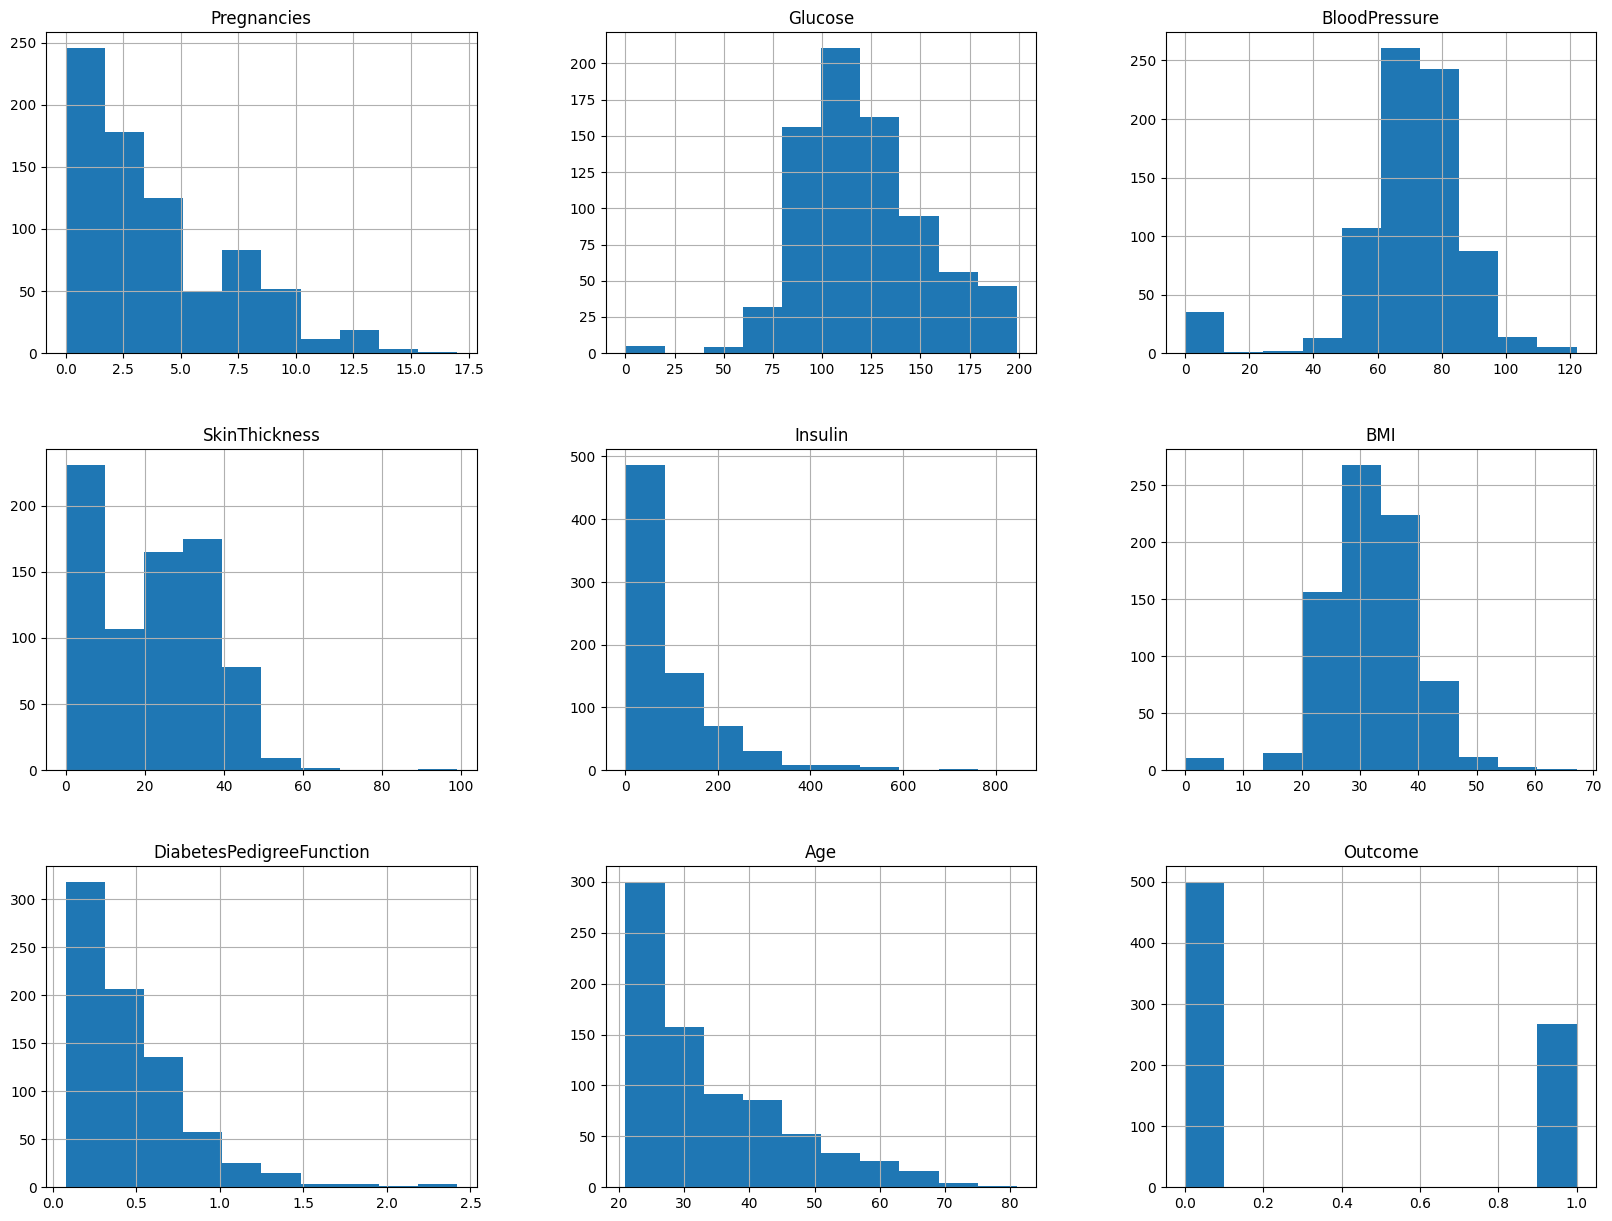

In [9]:
dataset_pandas.hist(figsize=(20, 15))
plt.show()

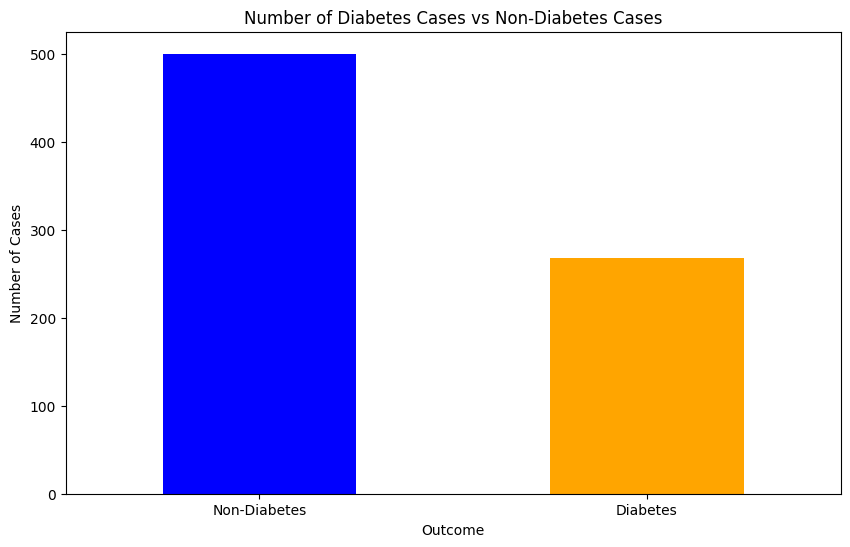

In [10]:
pandas_df = dataset.toPandas()
# ทำการ plot เพื่อดูจำนวนคนที่ไม่เป็นโรคเบาหวาน และเป็นโรคเบาหวาน
plt.figure(figsize=(10, 6))
pandas_df['Outcome'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Number of Diabetes Cases vs Non-Diabetes Cases')
plt.xlabel('Outcome')
plt.ylabel('Number of Cases')
plt.xticks([0, 1], ['Non-Diabetes', 'Diabetes'], rotation=0)
plt.show()

In [11]:
#pyspark.sql.functions. ฟังก์ชันนี้ใช้ในการอ้างอิงคอลัมน์ของ DataFrame ใน PySpark
from pyspark.sql.functions import col
#หลาย algorithm ของ machine learning ต้องการข้อมูลที่เป็น float เช่น อัลกอริทึมใน PySpark MLlib
#new_data: DataFrame ใหม่ที่มีคอลัมน์ทั้งหมดของ dataset แต่ชนิดข้อมูลของทุกคอลัมน์จะถูกแปลงเป็น float
new_data = dataset.select(*(col(c).cast("float").alias(c) for c in dataset.columns))

In [12]:
new_data.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction| Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+
|        6.0|  148.0|         72.0|         35.0|    0.0|33.6|                   0.627|50.0|    1.0|
|        1.0|   85.0|         66.0|         29.0|    0.0|26.6|                   0.351|31.0|    0.0|
|        8.0|  183.0|         64.0|          0.0|    0.0|23.3|                   0.672|32.0|    1.0|
|        1.0|   89.0|         66.0|         23.0|   94.0|28.1|                   0.167|21.0|    0.0|
|        0.0|  137.0|         40.0|         35.0|  168.0|43.1|                   2.288|33.0|    1.0|
|        5.0|  116.0|         74.0|          0.0|    0.0|25.6|                   0.201|30.0|    0.0|
|        3.0|   78.0|         50.0|         32.0|   88.0|31.0|                   0.248|26.0

In [13]:
new_data.printSchema()

root
 |-- Pregnancies: float (nullable = true)
 |-- Glucose: float (nullable = true)
 |-- BloodPressure: float (nullable = true)
 |-- SkinThickness: float (nullable = true)
 |-- Insulin: float (nullable = true)
 |-- BMI: float (nullable = true)
 |-- DiabetesPedigreeFunction: float (nullable = true)
 |-- Age: float (nullable = true)
 |-- Outcome: float (nullable = true)



In [14]:
from pyspark.sql.functions import col, count, isnan, when
#checking for null or nan type values in our columns
new_data.select([count(when(col(c).isNull(), c)).alias(c) for c in new_data.columns]).show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [15]:
from pyspark.ml.feature import VectorAssembler
cols=new_data.columns
# outcome คือ label ที่ต้องการ predict เลยต้องลบออก เอาเฉพาะ feature มา train
cols.remove("Outcome")
assembler = VectorAssembler(inputCols=cols,outputCol="features")

#รวมคอลัมน์ต่าง ๆ ใน DataFrame new_data เข้าเป็นคอลัมน์เดียวชื่อ features และเก็บผลลัพธ์ไว้ใน DataFrame ใหม่ที่ชื่อว่า data ; 8 attributes
data=assembler.transform(new_data)
#แสดงผลลัพธ์โดยไม่ตัดข้อความ (truncate=False)
data.select("features",'Outcome').show(truncate=False)

+-----------------------------------------------------------------------+-------+
|features                                                               |Outcome|
+-----------------------------------------------------------------------+-------+
|[6.0,148.0,72.0,35.0,0.0,33.599998474121094,0.6269999742507935,50.0]   |1.0    |
|[1.0,85.0,66.0,29.0,0.0,26.600000381469727,0.35100001096725464,31.0]   |0.0    |
|[8.0,183.0,64.0,0.0,0.0,23.299999237060547,0.671999990940094,32.0]     |1.0    |
|[1.0,89.0,66.0,23.0,94.0,28.100000381469727,0.16699999570846558,21.0]  |0.0    |
|[0.0,137.0,40.0,35.0,168.0,43.099998474121094,2.2880001068115234,33.0] |1.0    |
|[5.0,116.0,74.0,0.0,0.0,25.600000381469727,0.20100000500679016,30.0]   |0.0    |
|[3.0,78.0,50.0,32.0,88.0,31.0,0.24799999594688416,26.0]                |1.0    |
|[10.0,115.0,0.0,0.0,0.0,35.29999923706055,0.1340000033378601,29.0]     |0.0    |
|[2.0,197.0,70.0,45.0,543.0,30.5,0.15800000727176666,53.0]              |1.0    |
|[8.0,125.0,96.0

In [16]:
new_data.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [17]:
cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [18]:
#การ Scale ข้อมูลใน Machine Learning คือการปรับค่าของแต่ละ feature ให้มีค่าอยู่ในช่วงเดียวกันหรือประมาณกัน เพื่อให้โมเดลสามารถเรียนรู้และทำนายผลได้ดีขึ้น โดยทั่วไปแล้ว Scale จะใช้กับข้อมูลที่มีค่าต่างกันมากๆ 
#เช่น ข้อมูลที่มีหน่วยวัดต่างกัน เช่น น้ำหนัก (kg), ความยาว (cm), อุณหภูมิ (Celsius) เป็นต้น
#กระจายข้อมูลให้มีค่า mean 0 และ std 1
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
data=standardscaler.fit(data).transform(data)

In [19]:
data.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+--------------------+--------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction| Age|Outcome|            features|     Scaled_features|
+-----------+-------+-------------+-------------+-------+----+------------------------+----+-------+--------------------+--------------------+
|        6.0|  148.0|         72.0|         35.0|    0.0|33.6|                   0.627|50.0|    1.0|[6.0,148.0,72.0,3...|[1.78063837321943...|
|        1.0|   85.0|         66.0|         29.0|    0.0|26.6|                   0.351|31.0|    0.0|[1.0,85.0,66.0,29...|[0.29677306220323...|
|        8.0|  183.0|         64.0|          0.0|    0.0|23.3|                   0.672|32.0|    1.0|[8.0,183.0,64.0,0...|[2.37418449762590...|
|        1.0|   89.0|         66.0|         23.0|   94.0|28.1|                   0.167|21.0|    0.0|[1.0,89.0,66.0,23...|[0.29677306220323...|

In [20]:
data.select("features",'Scaled_features','Outcome').show()

+--------------------+--------------------+-------+
|            features|     Scaled_features|Outcome|
+--------------------+--------------------+-------+
|[6.0,148.0,72.0,3...|[1.78063837321943...|    1.0|
|[1.0,85.0,66.0,29...|[0.29677306220323...|    0.0|
|[8.0,183.0,64.0,0...|[2.37418449762590...|    1.0|
|[1.0,89.0,66.0,23...|[0.29677306220323...|    0.0|
|[0.0,137.0,40.0,3...|[0.0,4.2849165233...|    1.0|
|[5.0,116.0,74.0,0...|[1.48386531101619...|    0.0|
|[3.0,78.0,50.0,32...|[0.89031918660971...|    1.0|
|[10.0,115.0,0.0,0...|[2.96773062203238...|    0.0|
|[2.0,197.0,70.0,4...|[0.59354612440647...|    1.0|
|[8.0,125.0,96.0,0...|[2.37418449762590...|    1.0|
|[4.0,110.0,92.0,0...|[1.18709224881295...|    0.0|
|[10.0,168.0,74.0,...|[2.96773062203238...|    1.0|
|[10.0,139.0,80.0,...|[2.96773062203238...|    0.0|
|[1.0,189.0,60.0,2...|[0.29677306220323...|    1.0|
|[5.0,166.0,72.0,1...|[1.48386531101619...|    1.0|
|[7.0,100.0,0.0,0....|[2.07741143542266...|    1.0|
|[0.0,118.0,

In [21]:
assembled_data = data.select("Scaled_features","Outcome")
assembled_data.show()

+--------------------+-------+
|     Scaled_features|Outcome|
+--------------------+-------+
|[1.78063837321943...|    1.0|
|[0.29677306220323...|    0.0|
|[2.37418449762590...|    1.0|
|[0.29677306220323...|    0.0|
|[0.0,4.2849165233...|    1.0|
|[1.48386531101619...|    0.0|
|[0.89031918660971...|    1.0|
|[2.96773062203238...|    0.0|
|[0.59354612440647...|    1.0|
|[2.37418449762590...|    1.0|
|[1.18709224881295...|    0.0|
|[2.96773062203238...|    1.0|
|[2.96773062203238...|    0.0|
|[0.29677306220323...|    1.0|
|[1.48386531101619...|    1.0|
|[2.07741143542266...|    1.0|
|[0.0,3.6906580274...|    1.0|
|[2.07741143542266...|    1.0|
|[0.29677306220323...|    0.0|
|[0.29677306220323...|    1.0|
+--------------------+-------+
only showing top 20 rows



In [22]:
# train 70%, test 30%
train, test = assembled_data.randomSplit([0.7, 0.3])
train.show()

+--------------------+-------+
|     Scaled_features|Outcome|
+--------------------+-------+
|(8,[0,1,6,7],[0.5...|    0.0|
|(8,[0,1,6,7],[0.5...|    0.0|
|(8,[0,1,6,7],[0.8...|    0.0|
|(8,[0,1,6,7],[1.7...|    0.0|
|(8,[0,1,6,7],[2.9...|    1.0|
|(8,[1,5,6,7],[3.0...|    0.0|
|(8,[1,5,6,7],[3.6...|    0.0|
|(8,[1,5,6,7],[3.7...|    1.0|
|(8,[1,5,6,7],[4.0...|    1.0|
|(8,[1,5,6,7],[4.3...|    1.0|
|(8,[1,5,6,7],[5.2...|    1.0|
|(8,[1,6,7],[2.940...|    0.0|
|[0.0,1.7827754878...|    0.0|
|[0.0,2.0955431172...|    0.0|
|[0.0,2.3144804578...|    0.0|
|[0.0,2.4395875096...|    0.0|
|[0.0,2.6272480873...|    0.0|
|[0.0,2.8461854279...|    0.0|
|[0.0,2.8461854279...|    0.0|
|[0.0,2.9087389538...|    0.0|
+--------------------+-------+
only showing top 20 rows



In [23]:
test.show()

+--------------------+-------+
|     Scaled_features|Outcome|
+--------------------+-------+
|(8,[0,1,6,7],[2.0...|    0.0|
|(8,[1,5,6,7],[2.2...|    0.0|
|(8,[1,5,6,7],[4.4...|    1.0|
|(8,[1,5,6,7],[4.5...|    1.0|
|[0.0,2.6272480873...|    0.0|
|[0.0,2.6898016132...|    0.0|
|[0.0,2.9087389538...|    0.0|
|[0.0,3.1589530573...|    0.0|
|[0.0,3.2527833462...|    1.0|
|[0.0,3.2527833462...|    0.0|
|[0.0,3.3153368721...|    0.0|
|[0.0,3.3466136350...|    1.0|
|[0.0,3.3778903979...|    0.0|
|[0.0,3.4091671609...|    1.0|
|[0.0,3.6906580274...|    0.0|
|[0.0,3.7219347903...|    0.0|
|[0.0,3.7844883162...|    1.0|
|[0.0,3.8470418421...|    1.0|
|[0.0,3.8783186051...|    0.0|
|[0.0,3.9095953680...|    0.0|
+--------------------+-------+
only showing top 20 rows



# Modelling

## Logistic Regression

In [24]:
from pyspark.ml.classification import LogisticRegression
# สร้างออบเจกต์ Logistic Regression
# labelCol="Outcome" กำหนด Outcome เป็น label ที่จะ predict
# featuresCol="Scaled_features" กำหนดคอลัมน์ Scaled_features เป็นคอลัมน์ที่ใช้ features สำหรับ train model
# maxIter=40 กำหนดจำนวนการทำซ้ำสูงสุด (maximum iterations)
log_regress = LogisticRegression(labelCol="Outcome", featuresCol="Scaled_features",maxIter=40)
# นำ train data มา train ให้กับ LogisticRegression model
model=log_regress.fit(train)

In [25]:
# นำ model ที่ train ไว้มา predict ชุุดข้อมูล test set
prediction_test=model.transform(test)
prediction_test.show()

+--------------------+-------+--------------------+--------------------+----------+
|     Scaled_features|Outcome|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|(8,[0,1,6,7],[2.0...|    0.0|[2.62610856294783...|[0.93252309727562...|       0.0|
|(8,[1,5,6,7],[2.2...|    0.0|[2.69542653417440...|[0.93675623418271...|       0.0|
|(8,[1,5,6,7],[4.4...|    1.0|[-1.4812004272598...|[0.18524617031341...|       1.0|
|(8,[1,5,6,7],[4.5...|    1.0|[-2.3697367722894...|[0.08550972101925...|       1.0|
|[0.0,2.6272480873...|    0.0|[3.06348009791255...|[0.95536094604281...|       0.0|
|[0.0,2.6898016132...|    0.0|[2.62004617355377...|[0.93214062716534...|       0.0|
|[0.0,2.9087389538...|    0.0|[1.29340797516414...|[0.78472346572666...|       0.0|
|[0.0,3.1589530573...|    0.0|[2.87721009560818...|[0.94670828344852...|       0.0|
|[0.0,3.2527833462...|    1.0|[1.91997269765685...|[0.87213538908417...|    

In [26]:
# เปรียบเทียบค่าควา่มจริงกับ ค่าที่ Logistic Regression Model ทำนายได้
prediction_test.select("Outcome","prediction").show()

+-------+----------+
|Outcome|prediction|
+-------+----------+
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       1.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
+-------+----------+
only showing top 20 rows



In [27]:
# ใช้เมธอด rdd เพื่อแปลง DataFrame ที่เลือกคอลัมน์แล้วเป็น RDD
# RDD (Resilient Distributed Dataset) เป็นโครงสร้างข้อมูลพื้นฐานใน Spark ที่สามารถจัดการข้อมูลแบบกระจายและรองรับการประมวลผลแบบ parallel
# แปลง DataFrame ที่มีการคาดการณ์ (predictions) เป็น RDD เพื่อให้สามารถใช้กับ API ของ PySpark MLlib ที่ต้องการ RDD และเพื่อทำการคำนวณเมตริกต่างๆ ที่เกี่ยวข้องกับการประเมินโมเดลการจำแนกประเภท
# Compute raw scores on the test set
predictionAndLabels = prediction_test.select("Outcome","prediction").rdd

In [28]:
predictionAndLabels.collect()

[Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=1.0, prediction=1.0),
 Row(Outcome=1.0, prediction=1.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=1.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=1.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=1.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=1.0, prediction=0.0),
 Row(Outcome=1.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=0.0),
 Row(Outcome=0.0, prediction=1.0),
 Row(Outcome=0.0, prediction=1.0),
 Row(Outcome=1.0, prediction=1.0),
 Row(Outcome=0.0, prediction=1.0),
 Row(Outcome=1.0, prediction=1.0),
 Row(Outcome=1.0, pr

In [29]:
#ประเมินประสิทธิภาพของ Logistic Regression model ด้วย AOC
# AUC (Area Under the Curve) คือ พื้นที่ใต้กราฟ ROC
# ค่า AUC ที่ใกล้ 1 บ่งบอกว่าโมเดลมีความสามารถดีในการแยกแยะระหว่างสองคลาส
# ค่า AUC ที่ใกล้ 0.5 แสดงว่าโมเดลไม่มีความสามารถในการแยกแยะ (คล้ายกับการทำนายแบบสุ่ม)
from pyspark.mllib.evaluation import BinaryClassificationMetrics
# สร้างออบเจ็กต์ BinaryClassificationMetrics จาก RDD ที่ประกอบด้วย Outcome และ prediction เพื่อเปรียบเทียบ
metrics = BinaryClassificationMetrics(predictionAndLabels)
# Area under ROC curve
AUC_LR = metrics.areaUnderROC
print("AUC_LR = " ,AUC_LR)

C:\Users\Acer\Desktop\Pyspark_Proj\my_venv\lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


AUC_LR =  0.7417065522363426


In [30]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# ประเมิน accuracy ของ  Logistic Regression model ในการทำนาย โรคเบาหวาน
# labelCol="Outcome" กำหนด Outcome เป็น ค่าความจริง (actual value)
# predictionCol="prediction" ชื่อของคอลัมน์ที่มีค่าที่โมเดลทำนาย
# metricName="accuracy" ต้องการคำนวณ accuracy ของโมเดล
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="accuracy")
accuracy_LR = evaluator_accuracy.evaluate(prediction_test)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="weightedPrecision")
precision_LR = evaluator_precision.evaluate(prediction_test)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="weightedRecall")
recall_LR = evaluator_recall.evaluate(prediction_test)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="f1")
f1_LR = evaluator_f1.evaluate(prediction_test)

print ("Accuracy_LR = " ,accuracy_LR)
print("Precision_LR = ", precision_LR)
print("Recall_LR = ", recall_LR)
print("F1-Score_LR = ", f1_LR)

Accuracy_LR =  0.7531380753138075
Precision_LR =  0.7489588088123688
Recall_LR =  0.7531380753138075
F1-Score_LR =  0.7469262609853518


## NaiveBayes

In [31]:
from pyspark.ml.classification import NaiveBayes
# smoothing=1.0: ตั้งค่าพารามิเตอร์การเรียบ (smoothing parameter) สำหรับการปรับค่าให้เหมาะสมใน Naive Bayes; โดยค่า smoothing นี้ใช้ในการจัดการกับปัญหาค่าศูนย์ (zero-frequency problem) โดยการเพิ่มค่าเล็กน้อยให้กับทุกๆ ฟีเจอร์
naive_bayes = NaiveBayes(featuresCol='Scaled_features',labelCol='Outcome',smoothing=1.0)
model = naive_bayes.fit(train)

In [32]:
prediction_test = model.transform(test)
prediction_test.select("Outcome","prediction").show()

+-------+----------+
|Outcome|prediction|
+-------+----------+
|    0.0|       1.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
+-------+----------+
only showing top 20 rows



In [33]:
predictionAndLabels = prediction_test.select("Outcome","prediction").rdd

In [34]:
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="accuracy")
accuracy_NB = evaluator_accuracy.evaluate(prediction_test)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="weightedPrecision")
precision_NB = evaluator_precision.evaluate(prediction_test)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="weightedRecall")
recall_NB = evaluator_recall.evaluate(prediction_test)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="f1")
f1_NB = evaluator_f1.evaluate(prediction_test) 

print ("Accuracy_NB",accuracy_NB)
print("Precision_NB = ", precision_NB)
print("Recall_NB = ", recall_NB)
print("F1-Score_NB = ", f1_NB)

Accuracy_NB 0.6401673640167364
Precision_NB =  0.6791555724610118
Recall_NB =  0.6401673640167364
F1-Score_NB =  0.5284491863250474


In [35]:
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Area under ROC curve
AUC_NB = metrics.areaUnderROC
print("Area under ROC = " , AUC_NB)

Area under ROC =  0.6931818181818181


## GBTClassifier (Gradient-Boosted Tree Classifier)

- GBTClassifier (Gradient-Boosted Tree Classifier) เป็นหนึ่งในอัลกอริธึมการเรียนรู้ของเครื่องที่ใช้สำหรับการจำแนกประเภท (classification) ซึ่งใช้เทคนิคการเรียนรู้แบบการเพิ่มประสิทธิภาพ (boosting) โดยการใช้ต้นไม้ตัดสิน (decision trees) หลายต้นเพื่อสร้างโมเดลที่มีความสามารถในการจำแนกประเภทได้ดีขึ้น
- ใน GBTClassifier, โมเดลจะใช้ต้นไม้ตัดสิน (decision trees) ขนาดเล็กที่เรียกว่า "stumps" ซึ่งเป็นต้นไม้ที่มีความลึกน้อย
ต้นไม้เหล่านี้จะถูกรวมเข้าด้วยกันเพื่อสร้างโมเดลที่สามารถจำแนกประเภทได้อย่างมีประสิทธิภาพ

In [36]:
from pyspark.ml.classification import GBTClassifier
gradient_boost_class = GBTClassifier(labelCol="Outcome", featuresCol="Scaled_features")
model = gradient_boost_class.fit(train)
prediction_test = model.transform(test)
prediction_test.select("Outcome","prediction").show()

+-------+----------+
|Outcome|prediction|
+-------+----------+
|    0.0|       1.0|
|    0.0|       0.0|
|    1.0|       1.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    0.0|       1.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       1.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    0.0|       0.0|
+-------+----------+
only showing top 20 rows



In [37]:
# แปลง DataFrame ที่มีการคาดการณ์ (predictions) เป็น RDD เพื่อให้สามารถใช้กับ API ของ PySpark MLlib ที่ต้องการ RDD และเพื่อทำการคำนวณเมตริกต่างๆ ที่เกี่ยวข้องกับการประเมินโมเดลการจำแนกประเภท
predictionAndLabels = prediction_test.select("Outcome","prediction").rdd

In [38]:
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Area under ROC curve
AUC_GBT = metrics.areaUnderROC
print("Area under ROC = " , AUC_GBT)

Area under ROC =  0.7153209109730848


In [39]:
evaluator_accuracy = MulticlassClassificationEvaluator( labelCol="Outcome", predictionCol="prediction", metricName="accuracy")
accuracy_GBT = evaluator_accuracy.evaluate(prediction_test)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="weightedPrecision")
precision_GBT = evaluator_precision.evaluate(prediction_test)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="weightedRecall")
recall_GBT = evaluator_recall.evaluate(prediction_test)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="f1")
f1_GBT = evaluator_f1.evaluate(prediction_test) 

print ("Accuracy_GBT",accuracy_GBT)
print("Precision_GBT = ", precision_GBT)
print("Recall_GBT = ", recall_GBT)
print("F1-Score_GBT = ", f1_GBT)


Accuracy_GBT 0.7322175732217573
Precision_GBT =  0.7273317913667194
Recall_GBT =  0.7322175732217573
F1-Score_GBT =  0.7278368008021132


## RandomForestClassifier

-  เป็นอัลกอริธึมการเรียนรู้ของเครื่องที่ใช้สำหรับการจำแนกประเภท (classification) ซึ่งอิงจากเทคนิคการสร้างหลายต้นไม้ตัดสิน (decision trees) และรวมผลลัพธ์ของต้นไม้เหล่านั้นเพื่อปรับปรุงประสิทธิภาพการจำแนกประเภทและลดความเสี่ยงจากการ overfitting
-  Overfitting คือ ปัญหาที่เกิดขึ้นเมื่อโมเดลการเรียนรู้ของเครื่อง (machine learning model) มีความสามารถในการปรับตัวกับชุดข้อมูลการฝึกฝน (training data) มากเกินไปจนเกิดการเรียนรู้รายละเอียดหรือความผันผวนที่ไม่เป็นตัวแทนของข้อมูลทั่วไป (generalization) ซึ่งทำให้โมเดลนั้นทำงานได้ดีบนชุดข้อมูลการฝึกฝน แต่มีประสิทธิภาพต่ำเมื่อทดสอบกับชุดข้อมูลใหม่ (testing data) ที่ไม่เคยเห็นมาก่อน

In [40]:
from pyspark.ml.classification import RandomForestClassifier
# numTrees=40: กำหนดจำนวนต้นไม้ (trees) ที่จะสร้างใน Random Forest
random_forest_classifier = RandomForestClassifier(labelCol="Outcome", featuresCol="Scaled_features", numTrees=40)
model = random_forest_classifier.fit(train)
prediction_test = model.transform(test)
prediction_test.select("Outcome","prediction").show()

+-------+----------+
|Outcome|prediction|
+-------+----------+
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       1.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
+-------+----------+
only showing top 20 rows



In [41]:
predictionAndLabels = prediction_test.select("Outcome","prediction").rdd

In [42]:
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Area under ROC curve
AUC_RF = metrics.areaUnderROC
print("Area under ROC = ", AUC_RF)

Area under ROC =  0.755


In [43]:
evaluator_accuracy = MulticlassClassificationEvaluator( labelCol="Outcome", predictionCol="prediction", metricName="accuracy")
accuracy_RF= evaluator_accuracy.evaluate(prediction_test)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="weightedPrecision")
precision_RF = evaluator_precision.evaluate(prediction_test)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="weightedRecall")
recall_RF = evaluator_recall.evaluate(prediction_test)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction", metricName="f1")
f1_RF = evaluator_f1.evaluate(prediction_test) 

print ("Accuracy_RF",accuracy_RF)
print("Precision_RF = ", precision_GBT)
print("Recall_RF = ", recall_GBT)
print("F1-Score_RF = ", f1_GBT)

Accuracy_RF 0.7573221757322176
Precision_RF =  0.7273317913667194
Recall_RF =  0.7322175732217573
F1-Score_RF =  0.7278368008021132


## Evaluation

### Compare F1-score of 4 models

In [44]:
print("F1-Score of LR : ",f1_LR)
print("F1-Score of NB : ",f1_NB)
print("F1-Score of GBT : ",f1_GBT)
print("F1-Score of RF : ",f1_RF)

F1-Score of LR :  0.7469262609853518
F1-Score of NB :  0.5284491863250474
F1-Score of GBT :  0.7278368008021132
F1-Score of RF :  0.7465734585678798


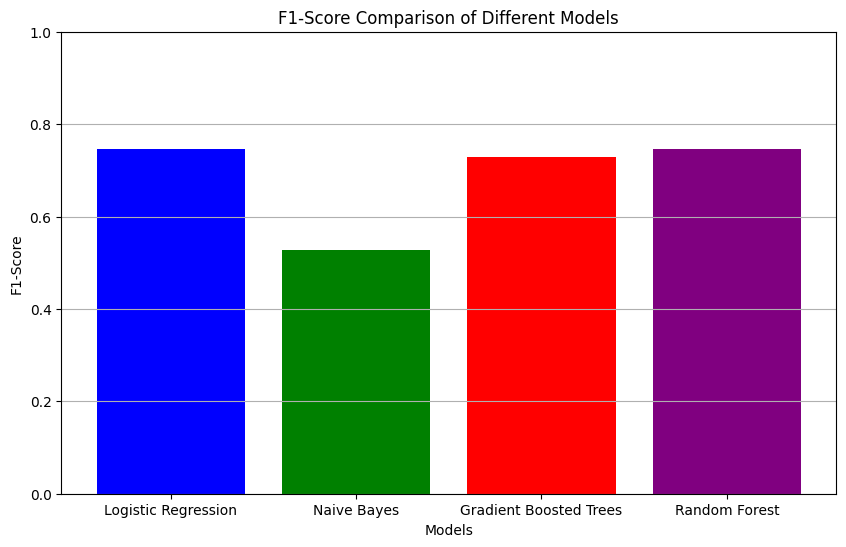

In [45]:
models = ['Logistic Regression', 'Naive Bayes', 'Gradient Boosted Trees', 'Random Forest']
f1_scores = [f1_LR, f1_NB, f1_GBT, f1_RF]

plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color=['blue', 'green', 'red', 'purple'])

plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison of Different Models')
plt.ylim(0, 1)
plt.grid(axis='y')

# แสดงกราฟ
plt.show()

- Logistic Regression, Random Forest เป็นโมเดลที่ให้ F1-Score สูงที่สุด บ่งบอกว่ามีประสิทธิภาพในการทำนายว่าเป็น โรคเบาหวาน ในข้อมูลทดสอบได้ดีที่สุด
- Gradient Boosted Trees มีค่า F1-Score ที่รองลงมา ถือเป็นตัวเลือกที่ดี แต่ไม่ดีเท่ากับ Logistic Regression, Random Forest
- Naive Bayes อาจไม่เหมาะสำหรับกรณีนี้เนื่องจากมี F1-Score ต่ำที่สุด

### Compare AUC of 4 models

In [46]:
print("AUC of LR : ",AUC_LR)
print("AUC of NB : ",AUC_NB)
print("AUC of GBT : ",AUC_GBT)
print("AUC of RF : ",AUC_RF)

AUC of LR :  0.7417065522363426
AUC of NB :  0.6931818181818181
AUC of GBT :  0.7153209109730848
AUC of RF :  0.755


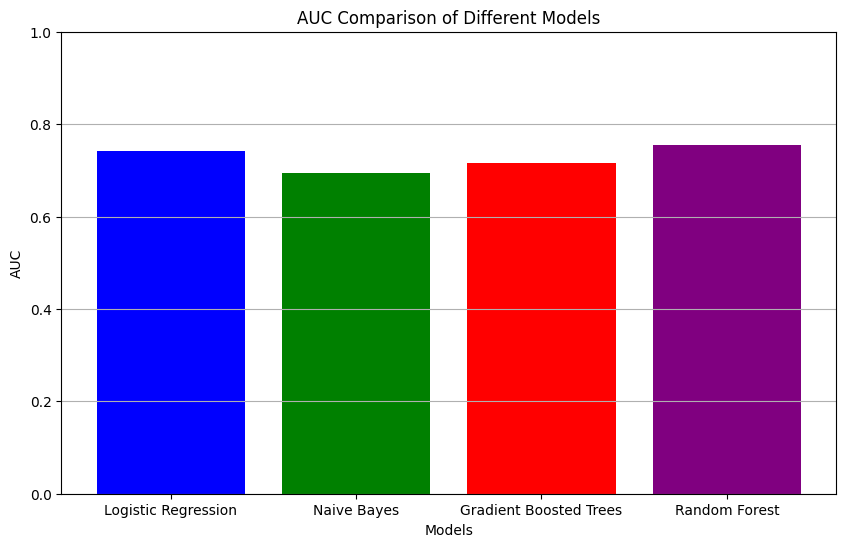

In [47]:
models = ['Logistic Regression', 'Naive Bayes', 'Gradient Boosted Trees', 'Random Forest']
f1_scores = [AUC_LR, AUC_NB, AUC_GBT, AUC_RF]

plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color=['blue', 'green', 'red', 'purple'])

plt.xlabel('Models')
plt.ylabel('AUC')
plt.title('AUC Comparison of Different Models')
plt.ylim(0, 1)
plt.grid(axis='y')

# แสดงกราฟ
plt.show()

- Random Forest มีค่า AUC สูงที่สุด ซึ่งแสดงให้เห็นความสามารถในการแยกแยะ positive class และ negative class ได้ดีที่สุด
- Logistic Regression เป็นตัวเลือกที่ดีอันดับสอง ในการการแยกแยะ positive class และ negative class
- Gradient Boosted Trees และ Naive Bayes มีค่า AUC น้อยที่สุด ซึ่งแแสดงความสามารถในการแยกแยะ class ได้แย่ที่สุดเมื่อเทียบกับโมเดลอื่น